In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_absolute_error, r2_score, make_scorer
from sklearn.feature_selection import SelectFromModel
from xgboost import XGBRegressor
from sklearn.impute import SimpleImputer
# Настройка визуализаций
%matplotlib inline

In [2]:
df = pd.read_excel('data/data.xlsx', index_col='Unnamed: 0')

In [3]:
# первичный осмотр данных
print("Первые строки:")
display(df.head())

print('\ninfo:')
df.info()

print("\nОсновные метрики наблюдаемых переменных:")
display(df[['IC50, mM', 'CC50, mM', 'SI']].describe())

# Анализ пропусков
nan_df = df.isnull()
missing = nan_df.sum()
missing = missing[missing > 0]
print('Столбцы с пропущенными значениями: ', ', '.join(missing.index.values))
print('Количество пропущенных значений: ', missing.any())
print('\nСоединения с пропущенными значениями:')
nan_df.loc[nan_df['MaxPartialCharge']==True][missing.index.values]

Первые строки:


,"IC50, mM","CC50, mM",SI,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,6.239374,175.482382,28.125000,5.094096,5.094096,0.387225,0.387225,0.417362,42.928571,384.652,...,0,0,0,0,0,0,0,0,3,0
1,0.771831,5.402819,7.000000,3.961417,3.961417,0.533868,0.533868,0.462473,45.214286,388.684,...,0,0,0,0,0,0,0,0,3,0
2,223.808778,161.142320,0.720000,2.627117,2.627117,0.543231,0.543231,0.260923,42.187500,446.808,...,0,0,0,0,0,0,0,0,3,0
3,1.705624,107.855654,63.235294,5.097360,5.097360,0.390603,0.390603,0.377846,41.862069,398.679,...,0,0,0,0,0,0,0,0,4,0
4,107.131532,139.270991,1.300000,5.150510,5.150510,0.270476,0.270476,0.429038,36.514286,466.713,...,0,0,0,0,0,0,0,0,0,0



info:
<class 'pandas.core.frame.DataFrame'>
Index: 1001 entries, 0 to 1000
Columns: 213 entries, IC50, mM to fr_urea
dtypes: float64(107), int64(106)
memory usage: 1.6 MB

Основные метрики наблюдаемых переменных:


,"IC50, mM","CC50, mM",SI
count,1001.000000,1001.000000,1001.000000
mean,222.805156,589.110728,72.508823
std,402.169734,642.867508,684.482739
min,0.003517,0.700808,0.011489
25%,12.515396,99.999036,1.433333
50%,46.585183,411.039342,3.846154
75%,224.975928,894.089176,16.566667
max,4128.529377,4538.976189,15620.600000


Столбцы с пропущенными значениями:  MaxPartialCharge, MinPartialCharge, MaxAbsPartialCharge, MinAbsPartialCharge, BCUT2D_MWHI, BCUT2D_MWLOW, BCUT2D_CHGHI, BCUT2D_CHGLO, BCUT2D_LOGPHI, BCUT2D_LOGPLOW, BCUT2D_MRHI, BCUT2D_MRLOW
Количество пропущенных значений:  True

Соединения с пропущенными значениями:


,MaxPartialCharge,MinPartialCharge,MaxAbsPartialCharge,MinAbsPartialCharge,BCUT2D_MWHI,BCUT2D_MWLOW,BCUT2D_CHGHI,BCUT2D_CHGLO,BCUT2D_LOGPHI,BCUT2D_LOGPLOW,BCUT2D_MRHI,BCUT2D_MRLOW
78,True,True,True,True,True,True,True,True,True,True,True,True
79,True,True,True,True,True,True,True,True,True,True,True,True
80,True,True,True,True,True,True,True,True,True,True,True,True


In [4]:
# т. к. пустых значений не много, а заполнять их не представляется возможным - удаляем их
df.dropna(how='any', inplace=True)

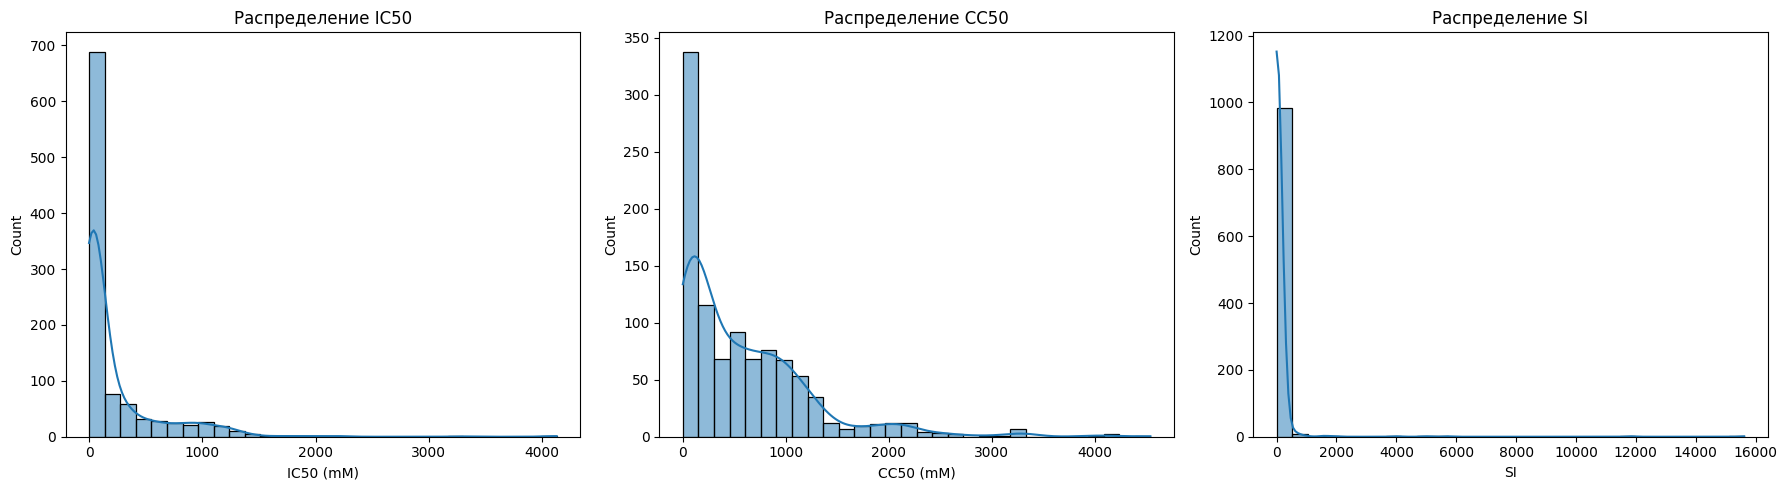

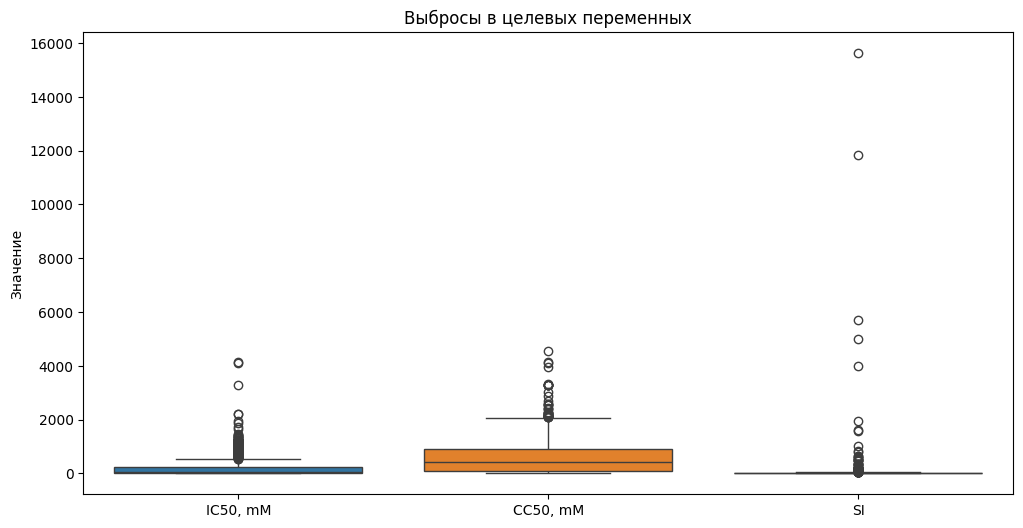

In [5]:
# Анализ целевых переменных (IC50, CC50, SI)
def plot_target_variables(df):
    _, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    sns.histplot(df['IC50, mM'], kde=True, ax=axes[0], bins=30)
    axes[0].set_title('Распределение IC50')
    axes[0].set_xlabel('IC50 (mM)')
    
    sns.histplot(df['CC50, mM'], kde=True, ax=axes[1], bins=30)
    axes[1].set_title('Распределение CC50')
    axes[1].set_xlabel('CC50 (mM)')
    
    sns.histplot(df['SI'], kde=True, ax=axes[2], bins=30)
    axes[2].set_title('Распределение SI')
    axes[2].set_xlabel('SI')
    
    plt.tight_layout()
    plt.show()

plot_target_variables(df)

# Проверка на выбросы
def plot_target_boxplots(df):
    plt.figure(figsize=(12, 6))
    sns.boxplot(data=df[['IC50, mM', 'CC50, mM', 'SI']])
    plt.title('Выбросы в целевых переменных')
    plt.ylabel('Значение')
    plt.show()

plot_target_boxplots(df)

# Анализ признаков
example_features = ['MolWt', 'MolLogP', 'NumHDonors', 'NumHAcceptors', 'RingCount']

In [6]:
# Анализ корреляции с SI
# Рассматриваем только SI, т. к. оно зависит от других переменных
correlation_with_SI = df.corr()['SI'].abs().sort_values(ascending=False)

print("Топ 20 признаков по абсолютной корреляции с SI:")
print(correlation_with_SI.head(20))

Топ 20 признаков по абсолютной корреляции с SI:
SI                          1.000000
BalabanJ                    0.164715
fr_NH2                      0.160428
RingCount                   0.124835
fr_Al_COO                   0.102374
fr_COO2                     0.101075
fr_COO                      0.101075
NumAromaticRings            0.088006
FpDensityMorgan1            0.087894
VSA_EState4                 0.087770
VSA_EState6                 0.083298
NHOHCount                   0.079056
fr_benzene                  0.078621
NumAromaticCarbocycles      0.078621
SMR_VSA7                    0.076668
MolLogP                     0.075862
AvgIpc                      0.075706
NumAliphaticHeterocycles    0.075564
BCUT2D_LOGPHI               0.074508
EState_VSA2                 0.071871
Name: SI, dtype: float64
